# Import necessary libraries and python files

Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
from torch.nn import Linear, Dropout, BatchNorm1d, LayerNorm, MultiheadAttention, TransformerEncoderLayer
from torch.optim.optimizer import Optimizer

In [4]:
import joblib

Ensure torch is connected to GPU

In [5]:
torch.__version__

'2.0.0+cu117'

In [6]:
torch.cuda.is_available()

True

In [7]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



Mount Drive and Load files/functions from other colab/jupyter notebooks

In [8]:
# Install the ipynb library
!pip install import-ipynb
import import_ipynb

Import Necessary Colab Notebooks

In [9]:
import dataset_prep
import Transformer_loss_activation_and_optimizer_functions
import Encoder_Transformer_Layers

importing Jupyter notebook from dataset_prep.ipynb
importing Jupyter notebook from Transformer_loss_activation_and_optimizer_functions.ipynb
importing Jupyter notebook from Encoder_Transformer_Layers.ipynb


In [10]:
from dataset_prep import *
from Transformer_loss_activation_and_optimizer_functions import get_loss_module, l2_reg_loss, MaskedMSELoss, _get_activation_fn, get_optimizer
from Encoder_Transformer_Layers import *

# Plotting helper functions

Plots the first n run-to-failure ensembles for the multi-dimensional sensors.

In [11]:
# Input: A dataframe containing run-to-failure data from a fleet of engines
# Args:
  # columns_names: A list of all column names [df.columns] ....
  # sensor_header: A list of the names of sensors to be plotted
# Output: It plots the first n-machines run-to-failure data for desired sensors
def plot_func(sensor_header, column_names, data_list, n_samples=10):
  for sensor_n in sensor_header:
    for d_ind in range(n_samples):
      plt.plot(data_list[d_ind][:,column_names.index(sensor_n)], label = 'ensemble-'+str(d_ind))
      plt.legend(loc='upper right')
      plt.title(sensor_n)
    plt.show()

Plots the training and validation losses.

In [12]:
# Helper function that plots, saves and shows plots
def plot_loss_accuracy(filename, train_losses, test_losses):
  loss = train_losses
  val_loss = test_losses

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')

  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.grid(True)
  plt.legend(loc=0)
  plt.title('Training and validation loss')
  plt.tight_layout()
  plt.figure()

  plt.savefig(filename + '.png')
  plt.show()

# Data Prep

Load data

In [13]:
# Create headers
index_col_names=['unit_id','time_cycle']
operat_set_col_names=['op_conditions_{}'.format(i) for i in range(1,4)]
sensor_measure_col_names=['sensor_{}'.format(i) for i in range(1,22)]
all_col=index_col_names+operat_set_col_names+sensor_measure_col_names
print(all_col)

['unit_id', 'time_cycle', 'op_conditions_1', 'op_conditions_2', 'op_conditions_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']


In [14]:
# Import Data - NASA dataset 260 train trajectories, 259 tests and 6 conditions
raw_train_df=pd.read_csv('C:/Users/Oluwaseyi/OneDrive - University of Victoria/Documents/NASA dataset/CMaps/train_FD001.txt',delim_whitespace=True,names=all_col)
raw_train_df.head()

unit_id  time_cycle  op_conditions_1  op_conditions_2  op_conditions_3  \
0        1           1          -0.0007          -0.0004            100.0   
1        1           2           0.0019          -0.0003            100.0   
2        1           3          -0.0043           0.0003            100.0   
3        1           4           0.0007           0.0000            100.0   
4        1           5          -0.0019          -0.0002            100.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  \
0    518.67    641.82   1589.70   1400.60     14.62  ...     521.66   
1    518.67    642.15   1591.82   1403.14     14.62  ...     522.28   
2    518.67    642.35   1587.99   1404.20     14.62  ...     522.42   
3    518.67    642.35   1582.79   1401.87     14.62  ...     522.86   
4    518.67    642.37   1582.85   1406.22     14.62  ...     522.19   

   sensor_13  sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  \
0    2388.02    8138.62     8.4195       0.03        392       2388   
1    2388.07    8131.49     8.4318       0.03        392       2388   
2    2388.03    8133.23     8.4178       0.03        390       2388   
3    2388.08    8133.83     8.3682       0.03        392       2388   
4    2388.04    8133.80     8.4294       0.03        393       2388   

   sensor_19  sensor_20  sensor_21  
0      100.0      39.06    23.4190  
1      100.0      39.00    23.4236  
2      100.0      38.95    23.3442  
3      100.0      38.88    23.3739  
4      100.0      38.90    23.4044  

[5 rows x 26 columns]

In [15]:
raw_train_df.shape

(20631, 26)

Import test dataset

In [16]:
test_df= pd.read_csv('C:/Users/Oluwaseyi/OneDrive - University of Victoria/Documents/NASA dataset/CMaps/test_FD001.txt',delim_whitespace=True,names=all_col)
y_test = pd.read_csv('C:/Users/Oluwaseyi/OneDrive - University of Victoria/Documents/NASA dataset/CMaps/RUL_FD001.txt', names=['RUL'])
print(test_df.shape, y_test.shape)

(13096, 26) (100, 1)


In [17]:
y_test.head()

RUL
0  112
1   98
2   69
3   82
4   91

Add RUL Column to dataframe

In [18]:
def RULCol(df):
  max_cycles_df = df.groupby('unit_id').max()['time_cycle'].reset_index().rename(columns={'time_cycle':'Maxcycle'})
  df = pd.merge(df, max_cycles_df, how='inner', on='unit_id')
  df['RUL'] = df['Maxcycle'] - df['time_cycle']
  return df

In [19]:
raw_train_df = RULCol(raw_train_df)
raw_train_df.head()

unit_id  time_cycle  op_conditions_1  op_conditions_2  op_conditions_3  \
0        1           1          -0.0007          -0.0004            100.0   
1        1           2           0.0019          -0.0003            100.0   
2        1           3          -0.0043           0.0003            100.0   
3        1           4           0.0007           0.0000            100.0   
4        1           5          -0.0019          -0.0002            100.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_14  \
0    518.67    641.82   1589.70   1400.60     14.62  ...    8138.62   
1    518.67    642.15   1591.82   1403.14     14.62  ...    8131.49   
2    518.67    642.35   1587.99   1404.20     14.62  ...    8133.23   
3    518.67    642.35   1582.79   1401.87     14.62  ...    8133.83   
4    518.67    642.37   1582.85   1406.22     14.62  ...    8133.80   

   sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  \
0     8.4195       0.03        392       2388      100.0      39.06   
1     8.4318       0.03        392       2388      100.0      39.00   
2     8.4178       0.03        390       2388      100.0      38.95   
3     8.3682       0.03        392       2388      100.0      38.88   
4     8.4294       0.03        393       2388      100.0      38.90   

   sensor_21  Maxcycle  RUL  
0    23.4190       192  191  
1    23.4236       192  190  
2    23.3442       192  189  
3    23.3739       192  188  
4    23.4044       192  187  

[5 rows x 28 columns]

Global Variables

*   T = constant window length when using sliding window
*   max_len = length of the longest ensemble in the training dataset, declare this when using the expanding window method.

*   Note: If max_len is greater than 512, then it has to be truncated because the encoder-transformer architecture can only take input sequences up to 512 tokens in length.


*  Data preparation methods when using sliding window (i.e max_len = T) is different from when expanding window method is adopted.








In [20]:
min_len = 5
T = 25
max_len = pd.unique(raw_train_df['Maxcycle']).max()
# max_len = T

Plots before normalization

In [21]:
# Something about np.where - It returns an array of the same shape as the condition
vals = raw_train_df.values
data_list = []  # List of arrays
for i in np.unique(raw_train_df['unit_id'].values):
  ind = np.where(raw_train_df['unit_id'].values == i)
  data_list.append(vals[ind])
print(len(data_list))

100


In [22]:
n_samples = 10
column_names = list(raw_train_df.columns)
sensor_header = list(column_names[5:-2])

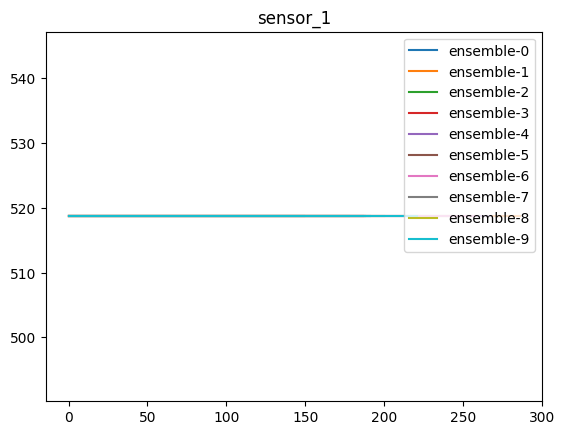

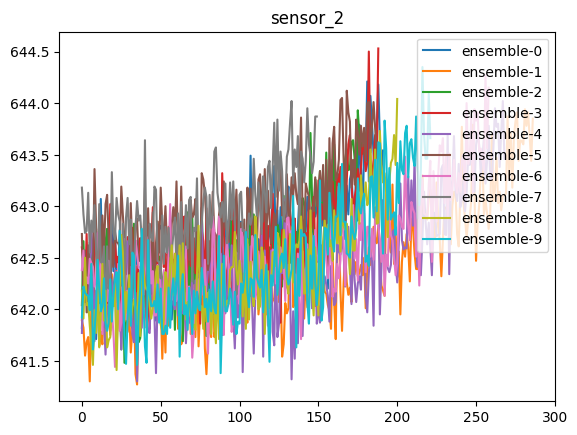

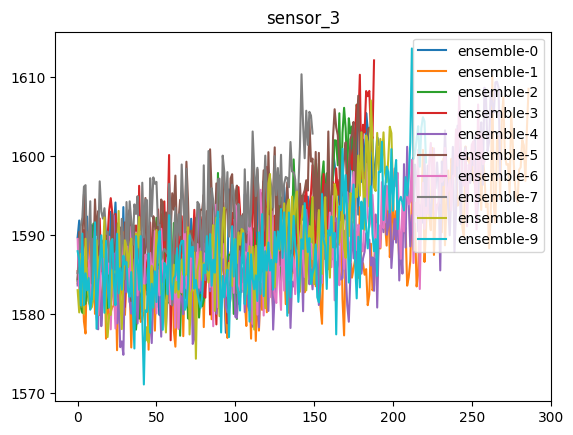

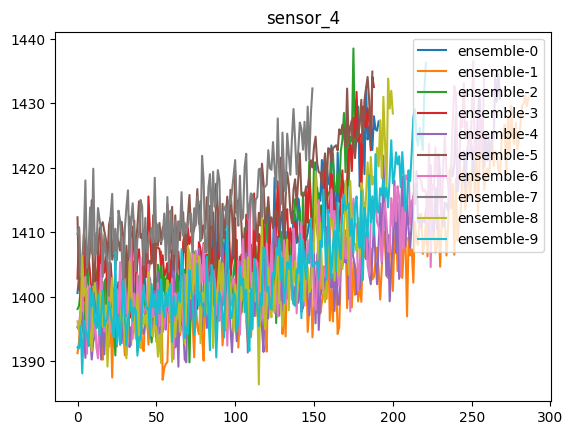

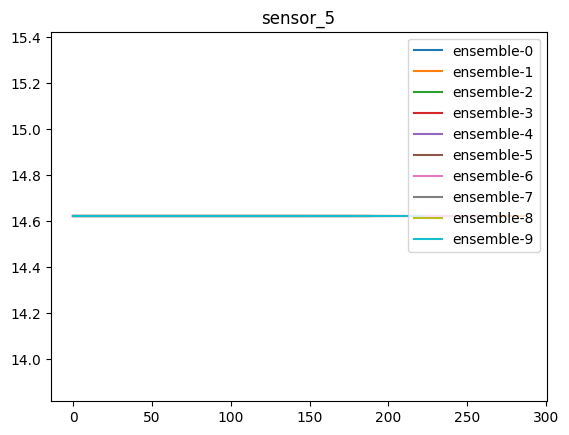

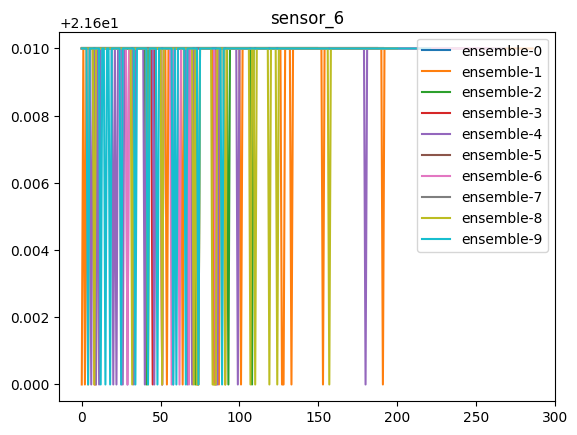

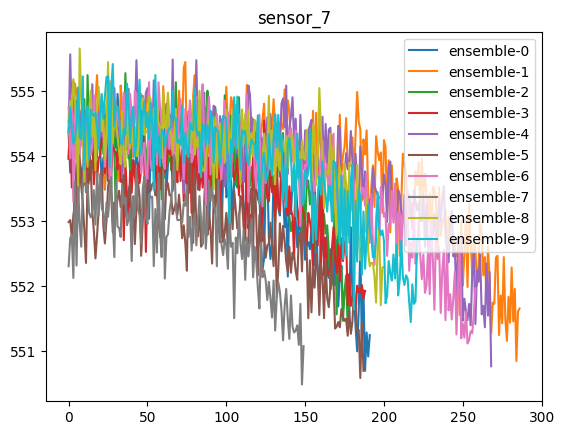

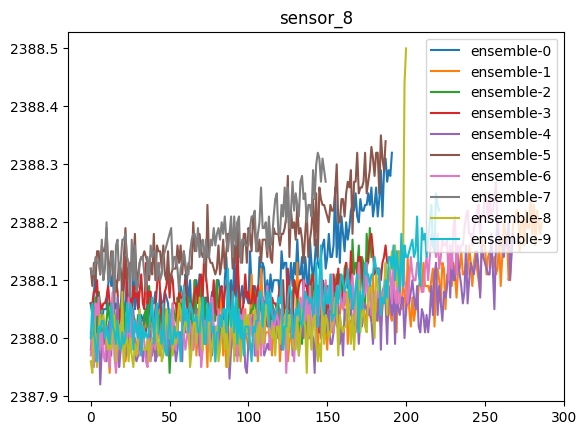

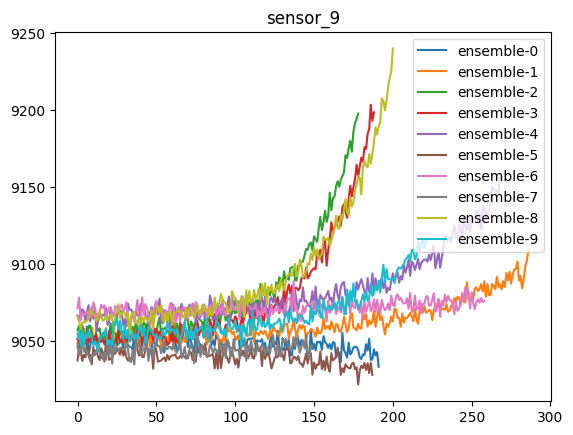

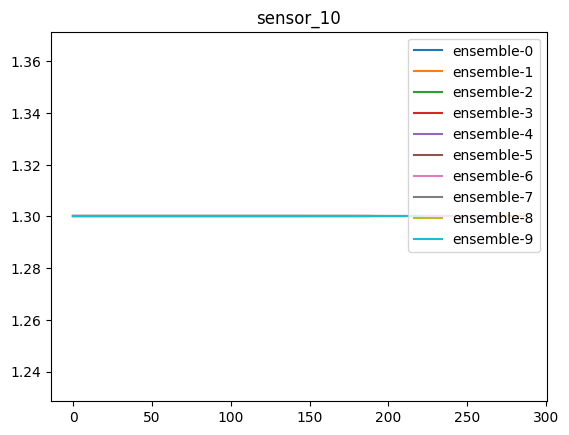

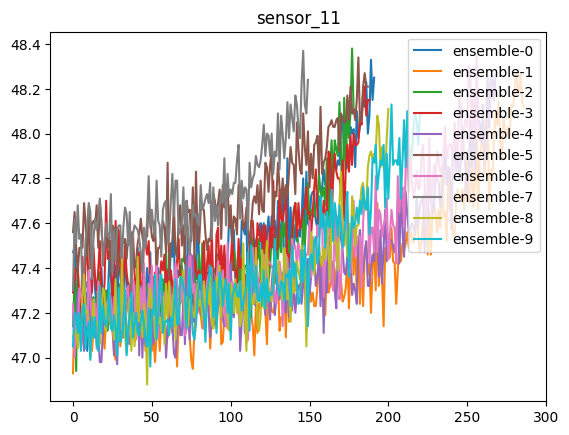

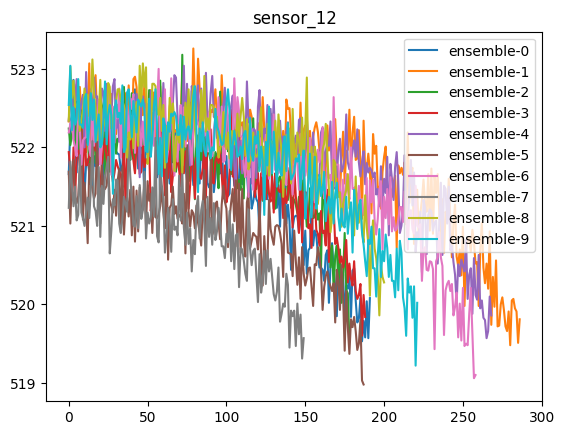

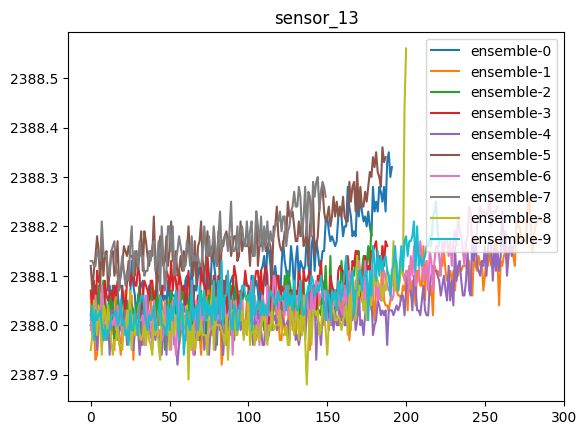

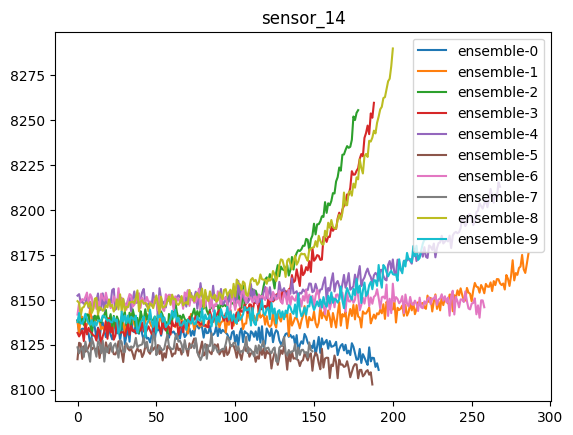

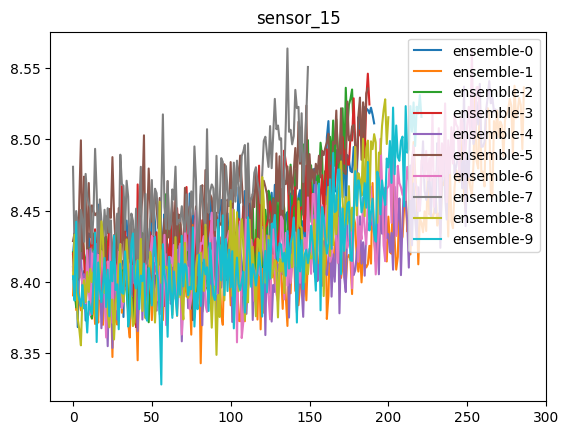

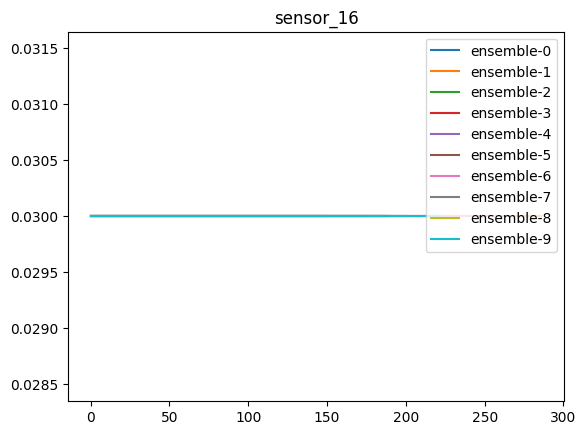

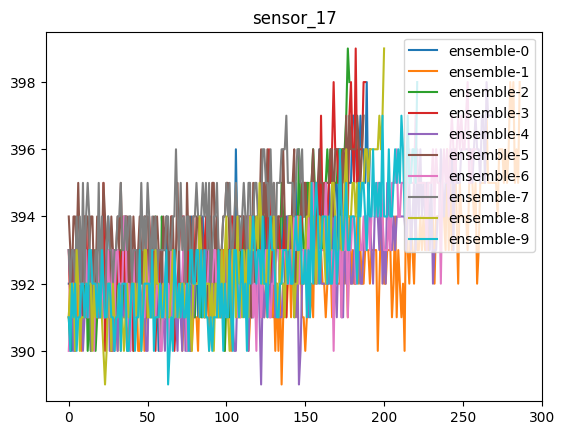

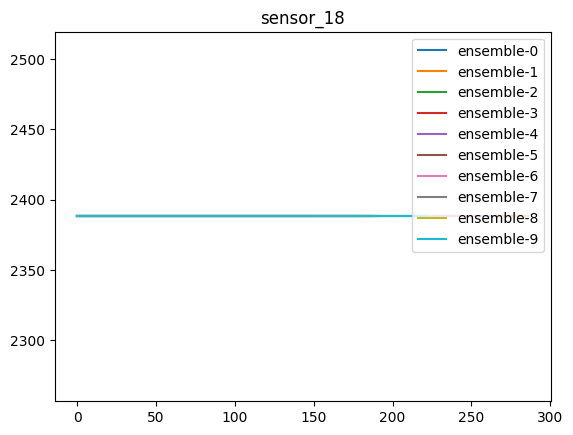

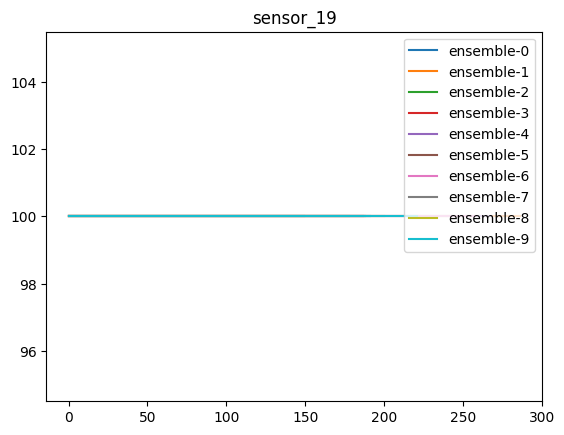

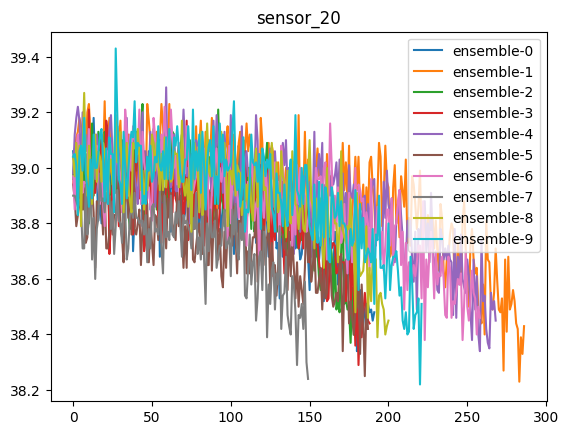

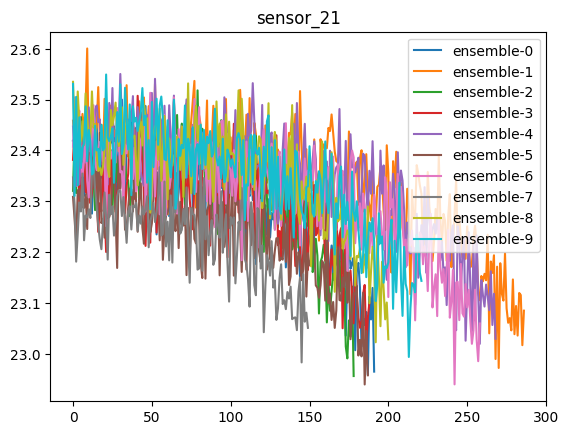

In [23]:
# Let's plot again  (Call split and Plot functions)
plot_func(sensor_header, column_names, data_list, n_samples)

Train - Val Split (Random)

In [24]:
# Args
  # Ensemble data: Dataframe of all run-to-failure data from a fleet of engines
# Returns:
  # Train and validation sets
  # Unit IDs of the machines in the train and val sets
train_df, val_df, train_id, val_id = train_val_split(df=raw_train_df, val_percent=0.2)

# Check
val_df.shape[0] + train_df.shape[0] == raw_train_df.shape[0]

True

Features and targets

In [25]:
ytrain_df = train_df.pop('RUL')
yval_df = val_df.pop('RUL')
print(train_df.shape, ytrain_df.shape, val_df.shape, yval_df.shape)

(16376, 27) (16376,) (4255, 27) (4255,)


In [26]:
train_df.drop(columns=['Maxcycle'], inplace=True)
val_df.drop(columns=['Maxcycle'], inplace=True)

# Normalization

Normalize data

In [27]:
# NOTE: Normalize data before the preparation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(train_df.iloc[:,5:])
traindf_scaled = scaler.transform(train_df.iloc[:,5:])

In [28]:
X_train_df = pd.concat([train_df.iloc[:,:5], traindf_scaled], axis=1)
X_train_df.head()

unit_id  time_cycle  op_conditions_1  op_conditions_2  op_conditions_3  \
0        1           1          -0.0007          -0.0004            100.0   
1        1           2           0.0019          -0.0003            100.0   
2        1           3          -0.0043           0.0003            100.0   
3        1           4           0.0007           0.0000            100.0   
4        1           5          -0.0019          -0.0002            100.0   

       sensor_1  sensor_2  sensor_3  sensor_4      sensor_5  ...  sensor_12  \
0  1.136868e-13 -1.720431 -0.132792 -0.924099 -3.552714e-15  ...   0.333859   
1  1.136868e-13 -1.060846  0.212128 -0.640755 -3.552714e-15  ...   1.181588   
2  1.136868e-13 -0.661098 -0.411005 -0.522510 -3.552714e-15  ...   1.373010   
3  1.136868e-13 -0.661098 -1.257034 -0.782427 -3.552714e-15  ...   1.974624   
4  1.136868e-13 -0.621123 -1.247272 -0.297173 -3.552714e-15  ...   1.058530   

   sensor_13  sensor_14  sensor_15     sensor_16  sensor_17  sensor_18  \
0  -1.074314  -0.293518  -0.604384 -1.387779e-17  -0.786046        0.0   
1  -0.361644  -0.679273  -0.275872 -1.387779e-17  -0.786046        0.0   
2  -0.931780  -0.585134  -0.649788 -1.387779e-17  -2.081500        0.0   
3  -0.219110  -0.552672  -1.974519 -1.387779e-17  -0.786046        0.0   
4  -0.789246  -0.554295  -0.339972 -1.387779e-17  -0.138318        0.0   

   sensor_19  sensor_20  sensor_21  
0        0.0   1.344863   1.195488  
1        0.0   1.012740   1.238041  
2        0.0   0.735970   0.503535  
3        0.0   0.348493   0.778281  
4        0.0   0.459201   1.060428  

[5 rows x 26 columns]

Transform/Scale validation data

In [29]:
valdf_scaled = scaler.transform(val_df.iloc[:,5:])
X_val_df = pd.concat([val_df.iloc[:,:5], valdf_scaled], axis=1)
X_val_df.head()

unit_id  time_cycle  op_conditions_1  op_conditions_2  op_conditions_3  \
8637       45           1           0.0019          -0.0003            100.0   
8638       45           2          -0.0008           0.0001            100.0   
8639       45           3           0.0026          -0.0000            100.0   
8640       45           4          -0.0006           0.0001            100.0   
8641       45           5          -0.0007           0.0000            100.0   

          sensor_1  sensor_2  sensor_3  sensor_4      sensor_5  ...  \
8637  1.136868e-13 -0.561161 -1.016241 -0.576055 -3.552714e-15  ...   
8638  1.136868e-13 -0.221375 -1.623104 -1.108161 -3.552714e-15  ...   
8639  1.136868e-13 -1.700443 -0.733147 -1.419393 -3.552714e-15  ...   
8640  1.136868e-13 -0.341299 -0.318267 -1.051269 -3.552714e-15  ...   
8641  1.136868e-13 -0.501199 -2.137229 -0.726651 -3.552714e-15  ...   

      sensor_12  sensor_13  sensor_14  sensor_15     sensor_16  sensor_17  \
8637   1.468722  -2.072051   0.358424  -1.344204 -1.387779e-17  -1.433773   
8638   1.523414  -1.501916   0.625152  -1.464391 -1.387779e-17  -2.081500   
8639   1.345664  -1.074314   0.665189  -0.703204 -1.387779e-17  -2.081500   
8640   1.386683  -1.929517   0.862665  -1.493770 -1.387779e-17  -0.786046   
8641   1.017511  -1.074314   0.485025  -1.082462 -1.387779e-17  -1.433773   

      sensor_18  sensor_19  sensor_20  sensor_21  
8637        0.0        0.0   1.843047   1.151085  
8638        0.0        0.0   1.068093   1.446182  
8639        0.0        0.0   0.846678   0.847661  
8640        0.0        0.0   0.403847   2.101132  
8641        0.0        0.0   1.068093   0.517411  

[5 rows x 26 columns]

Transform/Scale test data

In [30]:
testdf_scaled = scaler.transform(test_df.iloc[:,5:])
X_test_df = pd.concat([test_df.iloc[:,:5], testdf_scaled], axis=1)
X_test_df.head()

unit_id  time_cycle  op_conditions_1  op_conditions_2  op_conditions_3  \
0        1           1           0.0023           0.0003            100.0   
1        1           2          -0.0027          -0.0003            100.0   
2        1           3           0.0003           0.0001            100.0   
3        1           4           0.0042           0.0000            100.0   
4        1           5           0.0014           0.0000            100.0   

       sensor_1  sensor_2  sensor_3  sensor_4      sensor_5  ...  sensor_12  \
0  1.136868e-13  0.678058 -0.850289 -1.190710 -3.552714e-15  ...   0.415897   
1  1.136868e-13 -1.940292 -0.336164 -1.501942 -3.552714e-15  ...   1.017511   
2  1.136868e-13 -0.441236 -0.581838 -0.841550 -3.552714e-15  ...   0.757723   
3  1.136868e-13 -0.481211 -1.040645 -0.274863 -3.552714e-15  ...  -0.048986   
4  1.136868e-13 -0.341299 -0.541163 -0.776850 -3.552714e-15  ...   1.003838   

   sensor_13  sensor_14  sensor_15     sensor_16  sensor_17  sensor_18  \
0  -0.931780  -1.000645  -0.986312 -1.387779e-17  -0.786046        0.0   
1  -0.504178  -0.239415  -1.651349 -1.387779e-17  -0.138318        0.0   
2  -0.931780  -0.754476   0.052640 -1.387779e-17  -0.138318        0.0   
3  -0.646712  -0.602988  -1.346874 -1.387779e-17  -1.433773        0.0   
4  -0.931780  -0.784774  -1.042400 -1.387779e-17  -2.081500        0.0   

   sensor_19  sensor_20  sensor_21  
0        0.0   0.237786   0.774581  
1        0.0   1.123447   0.942019  
2        0.0   1.455570   1.173286  
3        0.0   1.012740   0.776431  
4        0.0   0.957386   1.139984  

[5 rows x 26 columns]

X data prep

In [31]:
norm_x_train = X_train_df.to_numpy()
norm_x_val = X_val_df.to_numpy()
norm_x_test = X_test_df.to_numpy()
print(norm_x_train.shape, norm_x_val.shape, norm_x_test.shape)

(16376, 26) (4255, 26) (13096, 26)


Y data prep

In [32]:
y_train = ytrain_df.to_numpy()
y_val = yval_df.to_numpy()
y_test = np.squeeze(y_test).to_numpy()
print(y_train.shape, y_val.shape, y_test.shape)

(16376,) (4255,) (100,)


Plots after normalization

In [33]:
vals = data_list = []  # List of arrays
for i in np.unique(norm_x_train[:,0]):
  ind = np.where(norm_x_train[:,0] == i)
  data_list.append(norm_x_train[ind])
print(len(data_list))

80


In [34]:
n_samples = 10
column_names= list(raw_train_df.columns)
sensor_header = list(column_names[5:-2])

In [35]:
raw_train_df.columns

Index(['unit_id', 'time_cycle', 'op_conditions_1', 'op_conditions_2',
       'op_conditions_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'Maxcycle', 'RUL'],
      dtype='object')

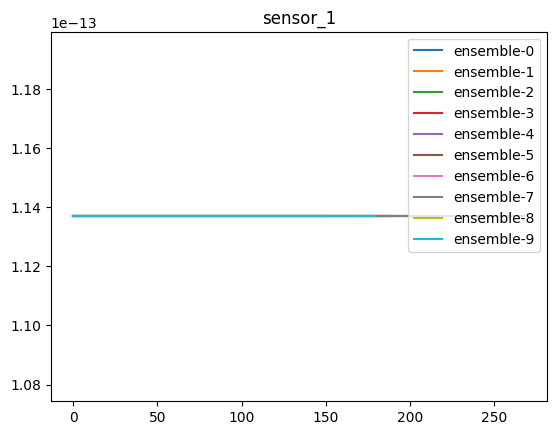

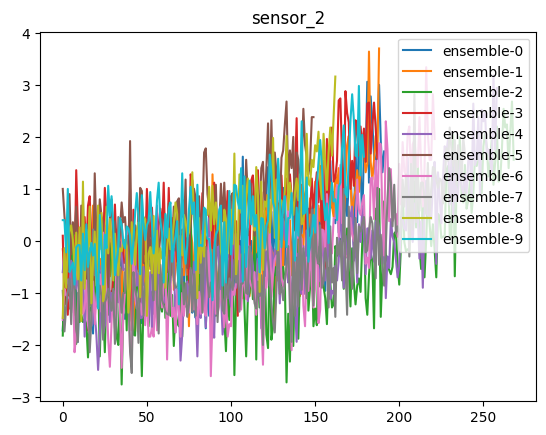

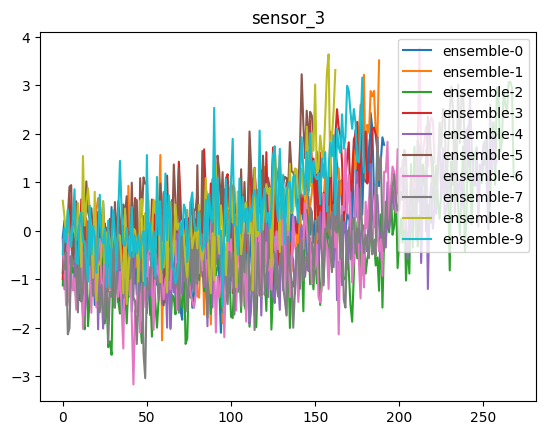

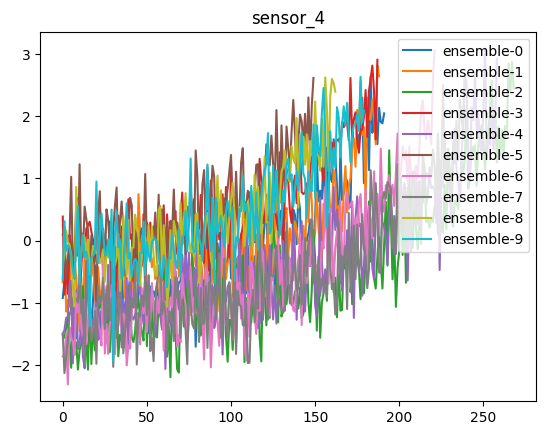

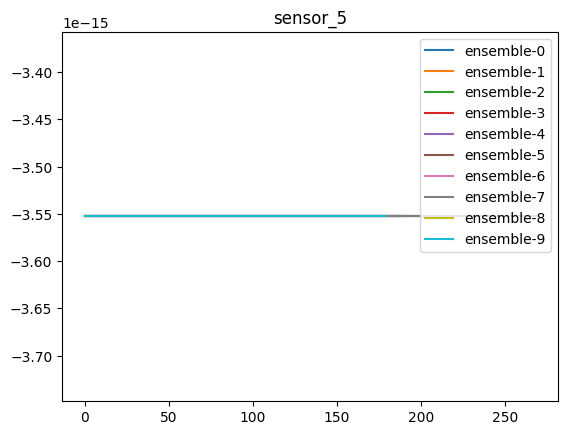

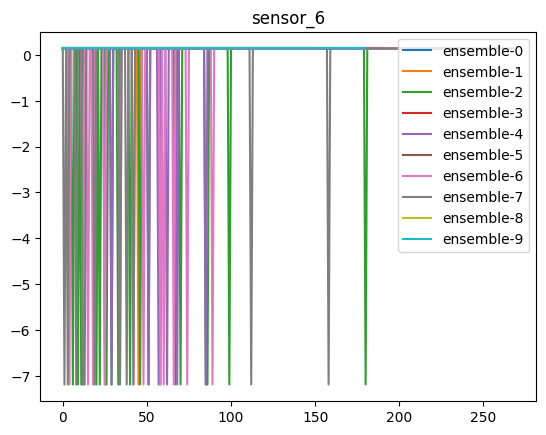

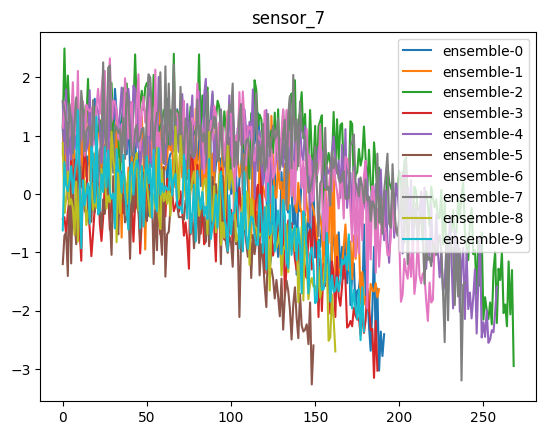

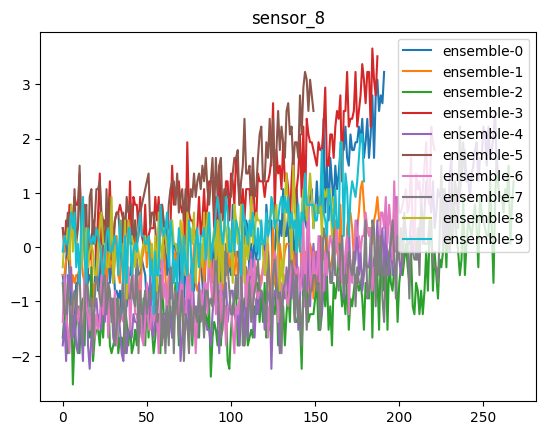

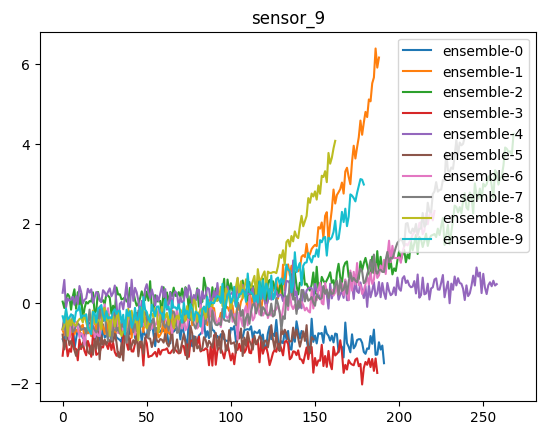

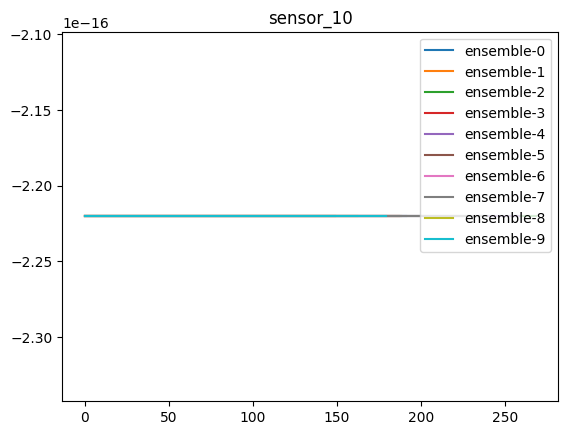

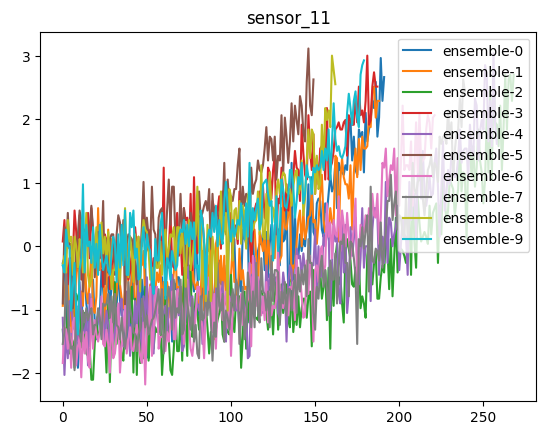

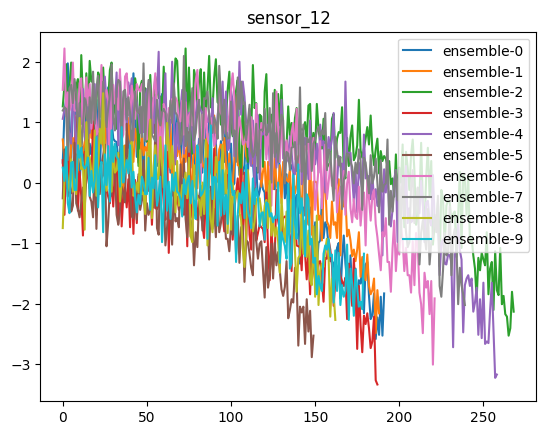

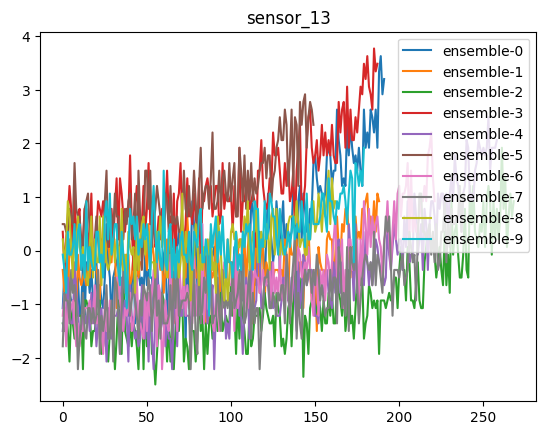

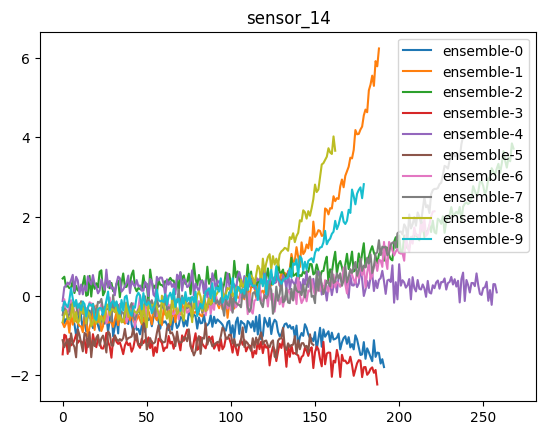

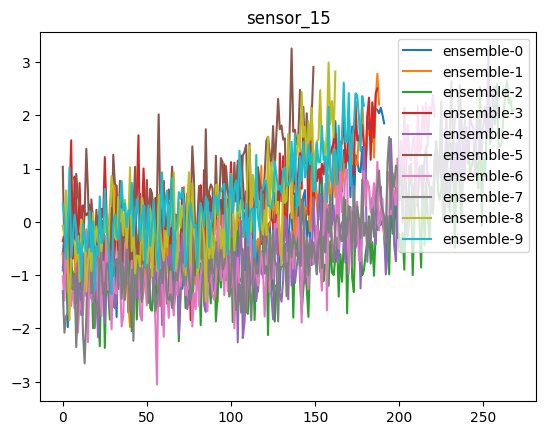

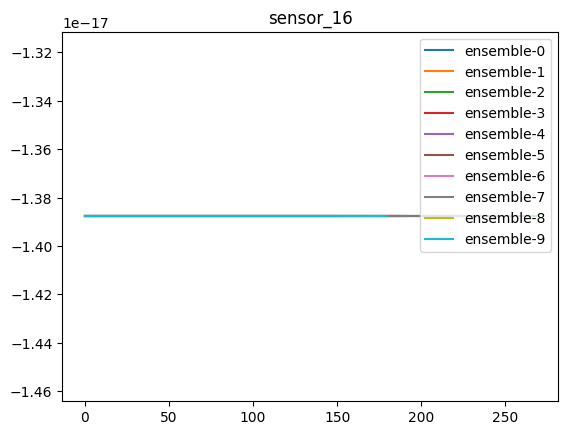

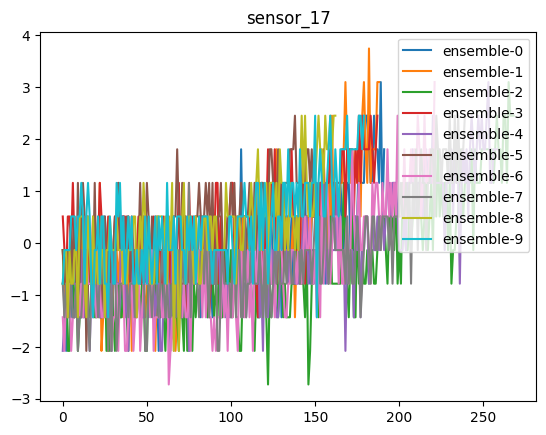

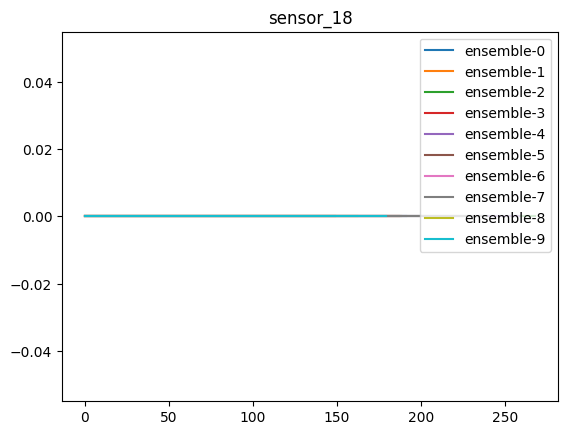

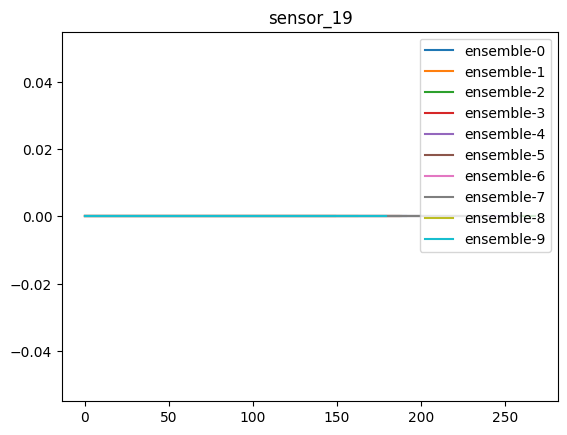

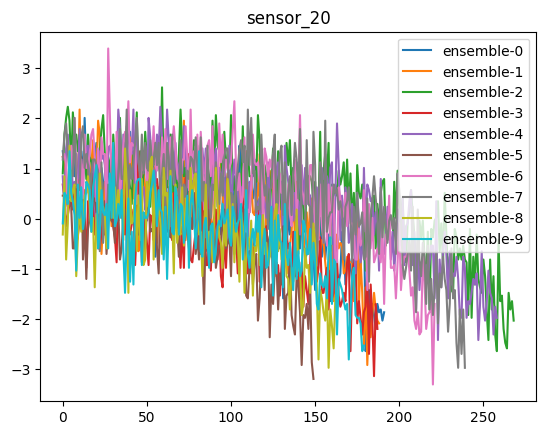

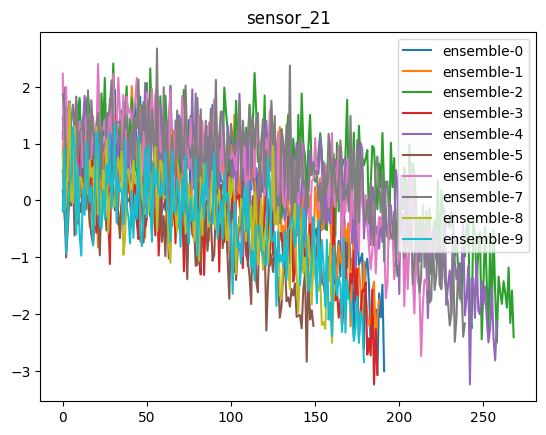

In [36]:
# Let's plot again  (Call split and Plot functions)
plot_func(sensor_header, column_names, data_list)

Feature Extraction

In [37]:
def featureExtraction(data, desired_sensors):
  cols = desired_sensors+4
  desired_cols = np.append(np.array([0]), cols)
  data = data[:,[desired_cols]]
  return data

In [38]:
desired_sensors = np.array([2,3,4,7,8,9,11,12,13,14,15,17,20,21])
# desired_sensors = np.array([2,3,4,7,11,12,15,17])
Enorm_x_train = np.squeeze(featureExtraction(norm_x_train, desired_sensors))
Enorm_x_val = np.squeeze(featureExtraction(norm_x_val, desired_sensors))
Enorm_x_test = np.squeeze(featureExtraction(norm_x_test, desired_sensors))
print(Enorm_x_train.shape, Enorm_x_val.shape, Enorm_x_test.shape)

(16376, 15) (4255, 15) (13096, 15)


# Expanding \ Sliding Window (train, Val and test)

X-train, val, test prep

In [39]:
if max_len == T:
  x_train_list = slidingWindow(Enorm_x_train, T)
  x_val_list = slidingWindow(Enorm_x_val, T)
  x_test_list = testSlidingWindow(Enorm_x_test,T)
else:
  x_train_list = expandWindow(Enorm_x_train, min_len=5)
  x_val_list = expandWindow(Enorm_x_val, min_len=5)
  x_test_list = testExpandWindow(Enorm_x_test)
print(len(x_train_list), len(x_val_list), len(x_test_list))

16056 4175 100


 Y-train and val prep

In [40]:
y_train_ind = np.array([Enorm_x_train[:,0], y_train])
y_val_ind =  np.array([Enorm_x_val[:,0], y_val])
y_train_ind = np.transpose(y_train_ind)
y_val_ind = np.transpose(y_val_ind)
print(y_train_ind.shape, y_val_ind.shape)

(16376, 2) (4255, 2)


In [41]:
if max_len == T:
  min_len = T

y_train_list = yPrep(y_train_ind, min_len)
y_val_list = yPrep(y_val_ind, min_len)
print(len(y_train_list), len(y_val_list))

80 20


In [42]:
print(checkY(y_train_list), checkY(y_val_list))

16056 4175


In [43]:
y_trainf = np.concatenate(y_train_list)
y_valf = np.concatenate(y_val_list)
print(y_trainf.shape, y_valf.shape)

(16056,) (4175,)


Use Piecewise RUL values

In [44]:
y_trainf = np.where(y_trainf>125, 125,y_trainf)
y_valf = np.where(y_valf>125, 125,y_valf)
y_testf = np.where(y_test>125, 125,y_test)
print(y_trainf.shape, y_valf.shape, y_testf.shape)

(16056,) (4175,) (100,)


Min-max normalization of y

In [45]:
y_trainf = y_trainf.reshape(-1,1)
y_valf = y_valf.reshape(-1,1)
y_testf = y_testf.reshape(-1,1)
print(y_trainf.shape, y_valf.shape, y_testf.shape)

(16056, 1) (4175, 1) (100, 1)


In [46]:
y_scaler = MinMaxScaler()
y_scaler.fit(y_trainf)
y_trainf = y_scaler.transform(y_trainf)
y_valf = y_scaler.transform(y_valf)
y_testf = y_scaler.transform(y_testf)
print(y_trainf.shape, y_valf.shape, y_testf.shape)

(16056, 1) (4175, 1) (100, 1)


In [47]:
y_trainf = y_trainf.squeeze()
y_valf = y_valf.squeeze()
y_testf = y_testf.squeeze()
print(y_trainf.shape, y_valf.shape, y_testf.shape)

(16056,) (4175,) (100,)


Prepare dataset for use in pytorch

In [48]:
def collate_superv(data, max_len=max_len):
    """Build mini-batch tensors from a list of (X, y) tuples.
    Args:
        data: len(batch_size) list of tuples (X, y).
            - X: torch tensor of shape (seq_length, feat_dim); variable seq_length.
            - y: torch tensor of shape (1);
        max_len: global fixed sequence length. Used for architectures requiring fixed length input,
            where the batch length cannot vary dynamically. Longer sequences are clipped, shorter are padded with 0s
    Returns:
        X: (batch_size, padded_length, feat_dim) torch tensor of masked features (input)
        y: (batch_size,1)
        padding_masks: (batch_size, padded_length) boolean tensor, 1 means keep vector at this position, 0 ignore (padding)
    """

    batch_size = len(data)
    features, targets = zip(*data)

    # Stack and pad features and masks (convert 2D to 3D tensors, i.e. add batch dimension)
    lengths = [X.shape[0] for X in features]  # original sequence length for each time series
    if max_len is None:
        max_len = max(lengths)

    X = torch.zeros(batch_size, max_len, features[0].shape[-1])  # (batch_size, padded_length, feat_dim)

    for i in range(batch_size):
        end = min(lengths[i], max_len)
        X[i, :end, :] = features[i][:end, :]

    padding_masks = padding_mask(torch.tensor(lengths, dtype=torch.int16), max_len=max_len)  # (batch_size, padded_length) boolean tensor, "1" means keep
    # X = x.clone().detach().requires_grad_(True)
    X = X.clone().detach().requires_grad_(True).type('torch.FloatTensor')
    targets = torch.tensor(targets, dtype=torch.float).reshape(-1,1)
    return X, targets, padding_masks

In [49]:
train_dataset = supDataset(data_list=x_train_list, targets=y_trainf)
train_dataloader = DataLoader(dataset=train_dataset,
                    collate_fn=collate_superv,
                    batch_size=128,
                    shuffle=False,
                    # num_workers=2,
                    pin_memory=True)

In [50]:
val_dataset = supDataset(data_list=x_val_list, targets=y_valf)
val_dataloader = DataLoader(dataset=val_dataset,
                    collate_fn=collate_superv,
                    batch_size=128,
                    shuffle=False,
                    # num_workers=2,
                    pin_memory=True)

In [51]:
test_dataset = supDataset(data_list=x_test_list, targets=y_testf)
test_dataloader = DataLoader(dataset=test_dataset,
                    collate_fn=collate_superv,
                    batch_size=y_testf.shape[0],
                    shuffle=False,
                    # num_workers=2,
                    pin_memory=True)

# Training and Validation

Create device Object

In [52]:
# Create device object to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Train Function

In [53]:
from datetime import datetime
def train_eval(model, criterion, optimizer, train_dataloader, val_dataloader, patience, epochs, exp_no, transform):
  # Collect the train and test loss per epoch
  train_losses = []
  test_losses = []

  # early_stop_thresh = patience
  best_loss = float('inf')
  best_epoch = -1
  patience=patience

  # Loop over no of epochs
  for epoch in range(epochs):
    t0 = datetime.now()
    # Put model in training mode
    model.train()

    # accumulate loss per batch in one epoch
    train_epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    for batch in train_dataloader:

      X, targets, padding_masks = batch[0], batch[1], batch[2]

      # move data to GPU/ any available device
      X = X.to(device)
      targets = targets.to(device)
      padding_masks = padding_masks.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward Pass
      # regression: (batch_size, num_labels); classification: (batch_size, num_classes) of logits
      predictions = model(X, padding_masks, transform)
      loss = criterion(predictions, targets)  # (batch_size,) loss for each sample in the batch

      # Backward and optimize
      loss.backward()   # Compute Gradients (Back prop)
      optimizer.step()  # Update weights(GD/Adam)

      # Loss of this batch in this epoch
      train_epoch_loss += float(loss.item())*(X.shape[0])
      total_samples += X.shape[0]

    # Get average train loss
    train_epoch_loss = train_epoch_loss / total_samples

    # Make predictions with model at the end of each epoch
    test_epoch_loss = 0
    n_test = 0

    for batch in val_dataloader:
      X, targets, padding_masks = batch[0], batch[1], batch[2]
      # Move test data to device
      X = X.to(device)
      targets = targets.to(device)
      padding_masks = padding_masks.to(device)

      with torch.inference_mode():
        model.eval()
        predictions = model(X, padding_masks, transform)

      loss = criterion(predictions, targets)

      test_epoch_loss += float(loss.item()) *(X.shape[0])
      n_test += X.shape[0]

    test_epoch_loss = test_epoch_loss / n_test

    # Save losses
    train_losses.append(train_epoch_loss)
    test_losses.append(test_epoch_loss)

    dt = datetime.now() - t0
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_epoch_loss:.4f}, \
      Test Loss: {test_epoch_loss:.4f}, Duration: {dt}')

    # MODEL TRACKING/CHECKPOINTS FUNCTIONS
    if test_epoch_loss < best_loss:
      best_loss = test_epoch_loss
      best_epoch = epoch
      torch.save(model, "best_model" + str(exp_no) + ".pt")
    if (epoch - best_epoch) > patience:
      print("Early stopped training at epoch %d" % (epoch+1))
      break  # terminate the training loop
    best_model = torch.load("best_model" + str(exp_no) + ".pt")
  return best_model, best_epoch, train_losses, test_losses

Score function

In [54]:
def score(errors):
  a1=10
  a2=13
  s1=0
  s2=0
  for err in errors:
    if err < 0:
      s1 += (np.exp(-1*(err/a1))) - 1
    if ((err > 0) or (err == 0)):
      s2 += (np.exp(err/a2)) - 1
  return [s1 , s2]

Put It All Together.

In [55]:
d_model = 18
transform = 'linear'

In [56]:
# Instantiate model
# Dropout 0.4 is the sweet spot
model = TSTransformerEncoderClassiregressor(feat_dim=14, max_len=max_len, d_model=d_model, n_heads=2, num_layers=2, dim_feedforward=10, num_classes=1,
                 dropout=0.4, pos_encoding='fixed', activation='gelu', norm='LayerNorm', freeze=False, transform=transform)
# Move model to the gpu if available ()
# Note: If you need to move a model to GPU via .cuda() ,
# please do so before constructing optimizers for it. Parameters of a model after .cuda() will be different objects with those before the call.
model.to(device)

# Instantiate loss and optimizer of choice
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


In [ ]:
# Call the train function
best_model, best_epoch, train_losses, val_losses = train_eval(model, criterion, optimizer, train_dataloader,
                                                              val_dataloader, patience=20, epochs=150, exp_no=1, transform=transform)

# Plot Loss
plot_loss_accuracy("Transformer", train_losses=train_losses, test_losses=val_losses)

# Validation

In [58]:
with torch.inference_mode():
  best_model.eval()

  for batch in val_dataloader:

    X, targets, padding_masks = batch[0], batch[1], batch[2]

    # move data to GPU/ any available device
    X = X.to(device)
    targets = targets.to(device)
    padding_masks = padding_masks.to(device)

    # Make predictions with best model
    y_pred = best_model(X, padding_masks, transform)

In [59]:
y_predb = torch.Tensor.cpu(y_pred).detach().numpy()
y_test = torch.Tensor.cpu(targets).detach().numpy()

# Inverse transform
y_predb = y_scaler.inverse_transform(y_predb)
y_test = y_scaler.inverse_transform(y_test)

# Get score and RMSE
RMSE = mean_squared_error(y_predb, y_test, squared=False)
MAE = mean_absolute_error(y_predb, y_test)
error = y_predb -  y_test
SCORES = score(error)
print(SCORES,RMSE, MAE)

[array([25.793592], dtype=float32), array([2.2850876], dtype=float32)] 3.339933 3.0108912


# Testing

In [60]:
with torch.inference_mode():
  best_model.eval()

  for batch in test_dataloader:

    X, targets, padding_masks = batch[0], batch[1], batch[2]

    # move data to GPU/ any available device
    X = X.to(device)
    targets = targets.to(device)
    padding_masks = padding_masks.to(device)

    # Make predictions with best model
    y_pred = best_model(X, padding_masks, transform)

In [ ]:
y_predb = torch.Tensor.cpu(y_pred).detach().numpy()
y_test = torch.Tensor.cpu(targets).detach().numpy()

# Inverse transform
y_predb = y_scaler.inverse_transform(y_predb)
y_test = y_scaler.inverse_transform(y_test)

# Get score and RMSE
RMSE = mean_squared_error(y_predb, y_test, squared=False)
MAE = mean_absolute_error(y_predb, y_test)
error = y_predb -  y_test
SCORES = score(error)
print(SCORES, RMSE, MAE)

In [ ]:
ind = np.argsort(-y_test.squeeze(1))
plt.figure(figsize=(10,8));
plt.plot(y_test[ind]);
plt.plot(y_predb[ind]);